# 02_data_cleaning
For cleaning the Data from missing values and errors

## Contents
* import packages
* setting variables
* defining functions
* loading data
* explorative analysis
* performing data cleaning

## import packages

In [35]:
import sys
import os

import yaml
import pandas as pd
import numpy as np
import pandas_profiling as pd_profil
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from functions.utils import get_folder

pd.set_option('display.float_format', '{:.2f}'.format)

## setting variables

In [2]:
curr_folder = get_folder()
parent_fold = curr_folder.parent
with open(parent_fold / "connections.yml", encoding='utf-8') as file:
    db_config = yaml.safe_load(file)
    
with open(parent_fold / "configurations" / "data_loads.yaml", encoding='utf-8') as file:
    column_conf = yaml.safe_load(file)
    
engine = create_engine(f'postgresql+psycopg2://{db_config["user"]}:{db_config["password"]}@{db_config["host"]}:{db_config["port"]}/{db_config["db"]}')

dates = ["01.05.2022","05.05.2022"]

## defining functions

In [54]:
def get_columns(engine,tablename='tbl_positionnew',ignore_columns = ['type','altitude']):
    """
    Get the columns from the database schema which are not to be ignored while loading data
    Inputs:
    -----------------
    engine: the database engine
        The database connection from where to load the data
    tablename: String
        The name of the table to get the column names of
    ignore_columns: List
        A List of column names which shouldn't be included in the final list
    Outputs:
    ---------------
    Return: List
        A List of column names which are included in the table
    """
    sqlstring = f"""
    SELECT DISTINCT column_name
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_schema = 'public' AND table_name = '{tablename}' AND column_name NOT IN ('{"','".join(ignore_columns)}')
    """
    df = pd.read_sql(sqlstring,con=engine)
    return df['column_name'].tolist()

def load_data(engine,tablename,columns, dates = []):
    """
    Loading the data in a dataframe from the database
    Inputs:
    -----------------
    engine: the database engine
        The database connection from where to load the data
    tablename: String
        The name of the table to get the data from
    columns: List
        A List of column names which should be included in the output
    dates: List
        A List with 2 values to select data between these two dates
    Outputs:
    -----------------
    return: DataFrame
        A Dataframe with the extracted data
    
    """
    
    sqlstring = f"""
    SELECT DISTINCT {','.join(columns)}
    FROM {tablename}

    """
    if len(dates) > 0:
        sqlstring = sqlstring + f" WHERE CAST(msgtime AS DATE) BETWEEN CAST('{dates[0]}' AS DATE) AND CAST('{dates[1]}' AS DATE)"
    df = pd.read_sql(sqlstring,con=engine)
    return df

import pickle

class simple_outlier_mask():
    """
    simple class for learning on training data a structure of the column and what are the outliers to be deleted
    """
    def __init__(self, column = pd.Series([0,0])):
        """
        initilization of the class
        """
        self.mean = column.mean()
        self.sstd = column.std() * 6 + self.mean

    def fit(self, column):
        """
        learning the structure of the given column
        """
        self.mean = column.mean()
        self.sstd = column.std() * 6 + self.mean

    def transform(self, column):
        """
        returning the corrected column where the outliers are deleted by the learned mean.
        """
        result = column.apply(lambda x: self.mean if x > self.sstd else x )
        return result

    def save(self,location):
        """
        saving the structure of the column to a file
        """
        output = {
            'mean': self.mean,
            'sstd': self.sstd
        }
        pickle.dump(output, open(location, 'wb'))

    def load(self,location):
        """
        loading the strucutre of the column from a file in to the object
        """
        data = pickle.load(open(location, 'rb'))
        self.mean = data['mean']
        self.sstd = data['sstd']


## data Loads

In [4]:
position_columns = get_columns(engine,'tbl_positionnew',column_conf['position_unrel_cols'])
static_columns = get_columns(engine,'tbl_staticnew',column_conf['static_unrel_cols'])

static_df = load_data(engine,'tbl_staticnew',static_columns,dates)
#position_df = load_data(engine,'tbl_positionnew',profile_columns)


* inspect missing data on static_df
* find a strategy to handle these data

In [5]:
static_df.describe()

,dimensiona,dimensionb,dimensionc,dimensiond,draught,imonumber,index,messagetype,mmsi,positionfixingdevicetype,shiplength,shiptype,shipwidth
count,4187047.00,4187047.00,4175684.00,4175684.00,3256397.00,2851264.00,5224086.00,5224086.00,5224086.00,5224086.00,4187047.00,4187047.00,4175684.00
mean,29.29,25.74,6.17,6.17,46.53,16406548.95,2643.77,9.26,264863602.35,1.89,55.03,55.91,12.34
std,36.64,26.29,5.78,5.19,27.78,80209451.35,1420.56,7.93,52092219.42,3.86,48.04,20.76,9.72
min,0.00,0.00,0.00,0.00,1.00,8.00,0.00,5.00,205203000.00,0.00,1.00,1.00,1.00
25%,8.00,10.00,3.00,3.00,30.00,8842806.00,1847.00,5.00,257095980.00,0.00,19.00,31.00,7.00
50%,16.00,16.00,5.00,5.00,43.00,9306029.00,2552.00,5.00,257570600.00,1.00,40.00,60.00,10.00
75%,36.00,32.00,7.00,8.00,59.00,9669750.00,3246.00,5.00,258261840.00,1.00,80.00,70.00,15.00
max,388.00,391.00,63.00,63.00,255.00,981346200.00,15341.00,24.00,999000000.00,15.00,491.00,99.00,124.00


## missing data
* huge mssing data on apart of the data sets. -> probably the ones with messagetype <> 5
* imo number also missing on a number of data, correspondig with draugt and destination

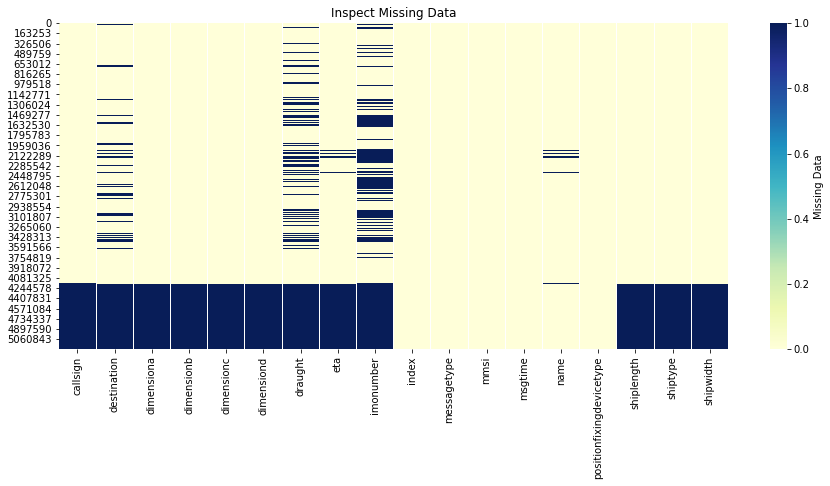

In [6]:
plt.figure(figsize=(15,6))
ax = plt.axes()
sns.heatmap(static_df.isna(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'},ax=ax)
ax.set_title('Inspect Missing Data')
plt.savefig("Inspect_missing_static_data.png", dpi=100)


In [7]:
static_df[static_df['messagetype'] == 24]

,callsign,destination,dimensiona,dimensionb,dimensionc,dimensiond,draught,eta,imonumber,index,messagetype,mmsi,msgtime,name,positionfixingdevicetype,shiplength,shiptype,shipwidth
15,1192C,None,6.00,0.00,48.00,0.00,NaN,None,NaN,39,24,941214991,2022-04-20 12:00:00,None,0,6.00,6.00,48.00
9620,3EDA3,None,172.00,28.00,22.00,10.00,NaN,None,NaN,3038,24,373965000,2022-04-18 15:20:00,None,1,200.00,70.00,32.00
64392,3YQU,None,10.00,5.00,2.00,3.00,NaN,None,NaN,19,24,257124940,2022-04-14 03:40:00,None,0,15.00,30.00,5.00
64393,3YQU,None,10.00,5.00,2.00,3.00,NaN,None,NaN,152,24,257124940,2022-04-17 23:00:00,None,0,15.00,30.00,5.00
64394,3YQU,None,10.00,5.00,2.00,3.00,NaN,None,NaN,491,24,257124940,2022-04-25 23:10:00,None,0,15.00,30.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5224081,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,15325,24,257659600,2022-04-08 09:00:00,MARIANNE S,0,NaN,NaN,NaN
5224082,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,15333,24,258089500,2022-04-08 09:00:00,FRIFANT,0,NaN,NaN,NaN
5224083,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,15338,24,257571490,2022-04-08 09:00:00,RACOON,0,NaN,NaN,NaN
5224084,None,None,NaN,NaN,NaN,NaN,NaN,None,NaN,15339,24,257318500,2022-04-08 09:00:00,STROENSTAD,0,NaN,NaN,NaN


In [8]:
static_df[static_df['messagetype'] == 24].describe()

,dimensiona,dimensionb,dimensionc,dimensiond,draught,imonumber,index,messagetype,mmsi,positionfixingdevicetype,shiplength,shiptype,shipwidth
count,134736.00,134736.00,134037.00,134037.00,0.00,0.00,1171775.00,1171775.00,1171775.00,1171775.00,134736.00,134736.00,134037.00
mean,5.96,8.88,3.32,3.17,NaN,NaN,2652.13,24.00,261389209.80,0.26,14.85,52.03,6.49
std,5.17,4.55,1.50,1.53,NaN,NaN,1414.76,0.00,51411519.74,1.93,6.53,17.07,2.50
min,0.00,0.00,0.00,0.00,NaN,NaN,0.00,24.00,209275000.00,0.00,2.00,6.00,1.00
25%,3.00,6.00,2.00,2.00,NaN,NaN,1862.00,24.00,257087880.00,0.00,13.00,33.00,5.00
50%,5.00,10.00,3.00,3.00,NaN,NaN,2554.00,24.00,257383900.00,0.00,15.00,53.00,6.00
75%,7.00,11.00,4.00,4.00,NaN,NaN,3244.00,24.00,257834800.00,0.00,15.00,70.00,8.00
max,253.00,326.00,48.00,27.00,NaN,NaN,15341.00,24.00,983107804.00,15.00,491.00,99.00,48.00


In [9]:
static_df[static_df['messagetype'] == 5].describe()

,dimensiona,dimensionb,dimensionc,dimensiond,draught,imonumber,index,messagetype,mmsi,positionfixingdevicetype,shiplength,shiptype,shipwidth
count,4052311.00,4052311.00,4041647.00,4041647.00,3256397.00,2851264.00,4052311.00,4052311.00,4052311.00,4052311.00,4052311.00,4052311.00,4041647.00
mean,30.07,26.30,6.26,6.27,46.53,16406548.95,2641.35,5.00,265868265.20,2.36,56.36,56.04,12.53
std,36.98,26.52,5.85,5.23,27.78,80209451.35,1422.22,0.00,52244358.05,4.14,48.25,20.86,9.81
min,0.00,0.00,0.00,0.00,1.00,8.00,0.00,5.00,205203000.00,0.00,1.00,1.00,1.00
25%,9.00,10.00,3.00,3.00,30.00,8842806.00,1842.00,5.00,257101740.00,1.00,21.00,30.00,7.00
50%,17.00,16.00,5.00,5.00,43.00,9306029.00,2552.00,5.00,257626000.00,1.00,41.00,60.00,10.00
75%,37.00,33.00,7.00,8.00,59.00,9669750.00,3247.00,5.00,258579000.00,1.00,81.00,70.00,15.00
max,388.00,391.00,63.00,63.00,255.00,981346200.00,15340.00,5.00,999000000.00,15.00,445.00,99.00,124.00


# strategies for imputation
* imonumber is the internatonal identifiaktion number of the owner of the ship. so this adress can be dropped and added to the ignored columns
* callsign is also not important for the identification of a ship set or type and can also be dropped as wella s name and positiondevicefinxingtype
* missing data for destination will be filled with "unknown"
* to be checking if we can find  additional data over the mmsi key which identifies a vessel so we can fill the mssing data abotut dimensions and the draught

In [10]:
static_df.drop(['imonumber','callsign','name','positionfixingdevicetype'],axis=1)
static_df['destination'].fillna("unknown",inplace=True)

In [11]:
static_df['mmsi'][static_df['draught'].isna()]

15         941214991
9620       373965000
17185      257097500
17186      257097500
17187      257097500
             ...    
5224081    257659600
5224082    258089500
5224083    257571490
5224084    257318500
5224085    257194500
Name: mmsi, Length: 1967689, dtype: int64

# test if there is some dato to find about the ships

In [12]:
sqlstring = f"""
SELECT DISTINCT
  tbl_staticnew.mmsi
, FILLER.draught
, FILLER.dimensiona
, FILLER.dimensionb
, FILLER.dimensionc
, FILLER.dimensiond
FROM tbl_staticnew
INNER JOIN (
SELECT DISTINCT
      mmsi
    , draught
    , dimensiona
    , dimensionb
    , dimensionc
    , dimensiond
    FROM tbl_staticnew
    WHERE draught is not null
) as FILLER ON 1=1
    AND tbl_staticnew.mmsi = FILLER.mmsi
WHERE 1=1
    AND tbl_staticnew.draught IS NULL
    AND CAST(tbl_staticnew.msgtime AS DATE) BETWEEN CAST('{dates[0]}' AS DATE) AND CAST('{dates[1]}' AS DATE)

"""
df = pd.read_sql(sqlstring,con=engine)

In [13]:
df.head()

,mmsi,draught,dimensiona,dimensionb,dimensionc,dimensiond
0,209275000,39.00,11.00,106.00,12.00,8.00
1,209275000,41.00,11.00,106.00,12.00,8.00
2,209275000,42.00,11.00,106.00,12.00,8.00
3,209275000,45.00,11.00,106.00,12.00,8.00
4,209275000,51.00,11.00,106.00,12.00,8.00


In [14]:
df.count()

mmsi          522
draught       522
dimensiona    522
dimensionb    522
dimensionc    521
dimensiond    521
dtype: int64

In [15]:
print("Number of NA's: ",static_df['draught'].isna().sum(),  "VS. number of entrys which can be filled with this strategy: ", len(df['mmsi'].unique()))

Number of NA's:  1967689 VS. number of entrys which can be filled with this strategy:  214


* conclusion:
  * for filling draugst and so on the best strategy would be probably to drop the missing rows.
  * also it would be possible to create avg sizes but this would be most probably wrong for the data
  * or keeping the value at zero
  * or at NaN
* noch mehr drüber nachdenken die infos könnten für die klassifizieurng von shciffen wichtig sein

## inspecting speed over ground
* einige daten aus position tbl sehen hier merkwürdig aus -> sehr hohe geschwindigkeiten ( 102 ist das maximum)

In [4]:
position_columns = get_columns(engine,'tbl_positionnew',column_conf['position_unrel_cols'])

position_df = load_data(engine,'tbl_positionnew',position_columns,dates)
position_df.head()

,aisclass,courseoverground,latitude,longitude,messagetype,mmsi,msgtime,navigationalstatus,rateofturn,speedoverground,trueheading
0,A,0.00,56.64,3.32,3,257095000,2022-04-20 17:10:00,6,0.00,0.10,0.00
1,A,0.00,56.64,3.32,3,257095000,2022-04-17 13:50:00,6,0.00,0.00,0.00
2,A,0.00,56.64,3.32,3,257095000,2022-04-18 09:20:00,6,0.00,0.10,0.00
3,A,0.00,56.64,3.32,3,257095000,2022-04-18 08:30:00,6,0.00,0.00,0.00
4,A,0.00,56.64,3.32,3,257095000,2022-04-17 12:50:00,6,0.00,0.00,0.00


In [5]:
position_df.shape

(6943639, 11)

## round the speed over ground and count numbers in each bucket umber


In [6]:
position_df['sog'] = position_df['speedoverground'].round()
grouped_speed = position_df[['sog','aisclass']].groupby(['sog']).count()

In [7]:

grouped_speed

,aisclass
sog,
0.00,5040538
1.00,161280
2.00,128227
3.00,107709
4.00,151880
...,...
83.00,1
85.00,1
95.00,2


<AxesSubplot:xlabel='sog'>

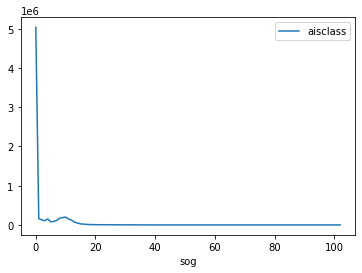

In [8]:
grouped_speed.plot()

## highspeed strategy
* very high speed is an error on the data. so 102 is reported if the speed over ground is not available as desribed here: 
https://faq.spire.com/why-does-ais-report-speed-over-ground-sog-as-102.3
* strategy: all data with to high speed will be replaced by the last correct value of the corresponding ship (grouped by mmsi and ordered by msgtime)

In [9]:
position_df[position_df['sog'] == 102].head()

,aisclass,courseoverground,latitude,longitude,messagetype,mmsi,msgtime,navigationalstatus,rateofturn,speedoverground,trueheading,sog
2131971,A,137.10,63.75,7.58,1,266469000,2022-04-12 13:20:00,0,21.00,102.20,215.00,102.00
3539461,A,214.30,62.96,7.45,3,257037600,2022-04-11 01:10:00,5,0.00,102.20,0.00,102.00
5237035,A,321.90,78.56,14.70,3,265511830,2022-04-28 23:30:00,0,0.00,102.20,0.00,102.00
5415760,A,336.60,61.53,4.45,3,311102000,2022-04-14 23:40:00,0,0.00,102.20,5.00,102.00
6629769,B,225.73,61.54,8.76,18,257007310,2022-04-27 08:30:00,0,0.00,102.20,0.00,102.00


In [10]:
position_df[position_df['sog'] == 98].head()

,aisclass,courseoverground,latitude,longitude,messagetype,mmsi,msgtime,navigationalstatus,rateofturn,speedoverground,trueheading,sog
6626446,B,224.43,61.32,8.31,18,257007310,2022-04-27 08:40:00,0,0.00,98.16,0.00,98.00


In [11]:
position_df[position_df['mmsi'] == 257007310] 

,aisclass,courseoverground,latitude,longitude,messagetype,mmsi,msgtime,navigationalstatus,rateofturn,speedoverground,trueheading,sog
5785514,B,0.00,59.73,10.58,18,257007310,2022-05-03 13:40:00,0,0.00,0.00,0.00,0.00
5785515,B,0.00,59.73,10.58,18,257007310,2022-05-03 13:50:00,0,0.00,0.00,0.00,0.00
5785516,B,0.00,59.73,10.58,18,257007310,2022-05-03 13:30:00,0,0.00,0.00,0.00,0.00
5785517,B,0.00,59.73,10.58,18,257007310,2022-05-03 14:00:00,0,0.00,0.00,0.00,0.00
5785518,B,0.00,59.73,10.58,18,257007310,2022-05-03 14:10:00,0,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6915921,B,346.50,59.73,10.58,18,257007310,2022-04-27 01:20:00,0,0.00,0.00,0.00,0.00
6915922,B,346.50,59.73,10.58,18,257007310,2022-04-27 01:10:00,0,0.00,0.00,0.00,0.00
6915923,B,346.50,59.73,10.58,18,257007310,2022-04-27 00:50:00,0,0.00,0.00,0.00,0.00
6915924,B,346.50,59.73,10.58,18,257007310,2022-04-27 00:10:00,0,0.00,0.00,0.00,0.00


In [12]:
position_df[position_df['mmsi'] == 257007310] .groupby(['sog']).count()

,aisclass,courseoverground,latitude,longitude,messagetype,mmsi,msgtime,navigationalstatus,rateofturn,speedoverground,trueheading
sog,,,,,,,,,,,
0.00,213,213,213,213,213,213,213,213,213,213,213
6.00,1,1,1,1,1,1,1,1,1,1,1
24.00,1,1,1,1,1,1,1,1,1,1,1
44.00,1,1,1,1,1,1,1,1,1,1,1
45.00,2,2,2,2,2,2,2,2,2,2,2
80.00,1,1,1,1,1,1,1,1,1,1,1
83.00,1,1,1,1,1,1,1,1,1,1,1
98.00,1,1,1,1,1,1,1,1,1,1,1
102.00,1,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:>

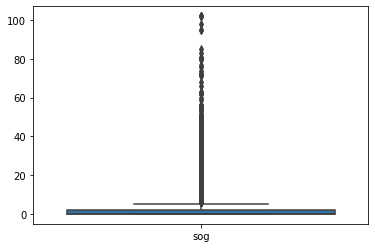

In [17]:
sns.boxplot(data=position_df[['sog']])

## nutze eine eigene Klasse um die Outlier zu ersetzen

In [59]:
SOM = simple_outlier_mask()
SOM.fit(position_df['sog'])
position_df['sog'] = SOM.transform(position_df['sog'])

# speichere die struktur um das z.B. im produktiven Umfeld weiter verwenden zu können auch wenn sich das datenset selbst ändert.
SOM.save(parent_fold / "modelle" / "simple_outlier_mask.pckl")


## Ergebnisse und nächste Schritte
* Es wurden in den stationären daten unrelevante datenfelder gefunden die nun ebenfalls nicht mehr selektiert werden -> zukünftige ausführungen dieses Notebooks werden sie nicht mehr enthalten
* Einige Datenfelder enthalten viele NaN Werte. Diese werden erstmal ignoriert. Da noch nicht klar ist ob das überhaupt relevante Features sind
* In den posiions daten gibt es bei dem feld "SpeedOverGround" unplausible geschwindigkeiten ( Outlier) Zur Behandlung wurde eine klasse geschrieben, welche verwendet werden kann um anhand der 6. Standardabweichung in der spalte die outlier zu identifizieren und durch den durchschnittswert zu ersetzen. Die gelernten Strukturen und Werte können gespeichert werden um so z.B. in einem produktiven Environment anzuwenden, auch wenn sich die grundgesamtheit verändert.

### nächste schritte
* start der transformationen und aggregationen der positionsdaten in neuem notebook